In [1]:
#Imports

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers, callbacks
print(tf.__version__)


2.6.0


My First Visual Studio Code, Tensorflow, & Jupyter Notebook Project

Code copied from https://www.kaggle.com/ryanholbrook/custom-convnets

In [2]:
#import and process annotations
cars_meta = scipy.io.loadmat('./Annos/cars_meta.mat')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)

train_annos = scipy.io.loadmat('./Annos/cars_train_annos.mat')
train_annos = train_annos['annotations']
train_annos = np.transpose(train_annos)

test_annos = scipy.io.loadmat('./Annos/cars_test_annos_withlabels.mat')
test_annos = test_annos['annotations']
test_annos = np.transpose(test_annos)

def format_annotations(data):

    annos = []
 
    for annotation in data:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        fname = annotation[0][5][0]
        annos.append([fname,[bbox_x1, bbox_y1, bbox_x2, bbox_y2],class_id])
    
    return(annos)

train_annotations = format_annotations(train_annos)
test_annotations = format_annotations(test_annos)

#get annotations train_annotations[0][2]. First index is the number of images.  Second index is [0] for frame name. [1] for box. [2] for class_id

#save labels as list
def labels_list(data):

    labels = []

    for label in data:
        labels.append(label[2])

    return(labels)

def fnames_list(data):

    fnames = []

    for fname in data:
        fnames.append(fname[0])
    
    return(fnames)

train_labels = labels_list(train_annotations)
test_labels = labels_list(test_annotations)


train_fnames = fnames_list(train_annotations)
test_fnames = fnames_list(test_annotations)



In [3]:
print(train_annotations[8143])
print(train_annotations[0][1])
index = 0
x1 = train_annotations[index][1][0]
y1 = train_annotations[index][1][1]
x2 = train_annotations[index][1][2]
y2 = train_annotations[index][1][3]
print(x1,y1,x2,y2)

print(test_annotations[0])
print(test_annotations[0][1])
index = 0
x1 = test_annotations[index][1][0]
y1 = test_annotations[index][1][1]
x2 = test_annotations[index][1][2]
y2 = test_annotations[index][1][3]
print(x1,y1,x2,y2)

['08144.jpg', [20, 240, 862, 677], 17]
[39, 116, 569, 375]
39 116 569 375
['00001.jpg', [30, 52, 246, 147], 181]
[30, 52, 246, 147]
30 52 246 147


In [4]:
#**Crop to bounding box.  Only run with full resolution images.**

# import PIL
# import os
# import os.path
# from PIL import Image

# f = r'./cars196_train'
# #f = r'./cars196_test'
# index = 0

# for file in sorted(os.listdir(f)):

#     # x1 = test_annotations[index][1][0]
#     # y1 = test_annotations[index][1][1] 
#     # x2 = test_annotations[index][1][2]
#     # y2 = test_annotations[index][1][3]

#     x1 = train_annotations[index][1][0]
#     y1 = train_annotations[index][1][1] 
#     x2 = train_annotations[index][1][2]
#     y2 = train_annotations[index][1][3]

    
    
#     f_img = f+"/"+file
#     print(f_img)
#     if(file != '.DS_Store'):
#         img = Image.open(f_img)
#         img = img.crop((x1,y1,x2,y2))
#         img.save(f_img)
#         index = index + 1

In [4]:
# Reproducability
# Setup the random seed so training data is feed in the same each run.
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
# The plotting layout presets.
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

directory_train = './cars196_train/'
directory_test = './cars196_test/'


# Create Datasets
ds_train = tf.data.Dataset.from_tensor_slices((train_fnames, train_labels))
ds_test = tf.data.Dataset.from_tensor_slices((test_fnames, test_labels))

def train_read_image(image_file, label):
    image = tf.io.read_file(directory_train + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def test_read_image(image_file, label):
    image = tf.io.read_file(directory_test + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label


def augment(image_file,label):
    image_size = [256,256]
    num_channels = 3
    interpolation = 'nearest'
    img = tf.image.resize(image_file, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img, label


def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label



def load_images(data):

    images = []

    for image in data:
        image = tf.io.read_file(directory_train + image)
        image = tf.image.decode_jpeg(image, channels=3)
        images.append(image)

    return images

# Putting it all together.  Take the training dataset which is sized and labeled.  Convert to pixel array.  Cache in memory for faster runtime.  Autotune sets up the CPU so it's fetching the next image in the list while the current image is in the CNN.  

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(train_read_image).map(augment).map(convert_to_float).batch(64).shuffle(100).cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.map(test_read_image).map(augment).map(convert_to_float).batch(64).cache().prefetch(buffer_size=AUTOTUNE)




2021-11-16 20:14:16.408595: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

# Reproducability
# Setup the random seed so training data is feed in the same each run.
# def set_seed(seed=31415):
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
# set_seed()

# # Set Matplotlib defaults
# # The plotting layout presets.
# plt.rc('figure', autolayout=True)
# plt.rc('axes', labelweight='bold', labelsize='large',
#        titleweight='bold', titlesize=18, titlepad=10)
# plt.rc('image', cmap='magma')


# #Create a tensorflow datasta (tf.data.Dataset).  Matches the images with the categorical label.  All the images are 128x128 and if they need to be resized use nearsest neighbor interpolation.    Shuffle the training set.  Do not shuffle the validation set.  It doesn't matter the order of the validation no need to shuffle. 
# ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
#     directory='./cars196_train',
#     labels=train_labels,
#     #Changed from binary to categorical_crossentropy because of the expanded labels.
#     label_mode='int',
#     image_size=[128, 128],
#     interpolation='nearest',
#     batch_size=64,
#     shuffle=True,
# )
# ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
#     directory='/cars196_test',
#     labels=test_labels,
#     #Changed from binary to categorical_crossentropy because of the expanded labels.
#     label_mode='int',
#     image_size=[128, 128],
#     interpolation='nearest',
#     batch_size=64,
#     shuffle=False,
# )

# # Data Pipeline
# # Process the images into pixel arrays so matrix operations can be preformed on them.  
# def convert_to_float(image, label):
#     image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#     return image, label

# # Putting it all together.  Take the training dataset which is sized and labeled.  Convert to pixel array.  Cache in memory for faster runtime.  Autotune sets up the CPU so it's fetching the next image in the list while the current image is in the CNN.  
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# ds_train = (
#     ds_train_
#     .map(convert_to_float)
#     .cache()
#     .prefetch(buffer_size=AUTOTUNE)
# )
# ds_valid = (
#     ds_valid_
#     .map(convert_to_float)
#     .cache()
#     .prefetch(buffer_size=AUTOTUNE)
# )



Load Pretrained Base

In [5]:
#InceptionV3 pretrained base for baseline.

pretrained_base = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=[256,256,3], pooling=max, classes=1000,
    classifier_activation='softmax'
)
pretrained_base.trainable = False



Early Stopping

In [6]:
# Stop early if the accucary is not improving enough.

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0005, # minimium amount of change to count as an improvement
    patience=15, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Attach Head

In [9]:




# Pretrained base model

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(units=2048, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=197, activation="Softmax"),
])

# Custom base  0.8051346 val_binary_accuracy

# model = keras.Sequential([

#     # First Convolutional Block
#     # 32 filter layers, Kernel Size of 5 x 5. Relu activation.  Add zeroes all around so the image doesn't change size, Padding='same'.
    
#     layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
#                   # give the input dimensions in the first layer
#                   # [height, width, color channels(RGB)]
#                   input_shape=[256, 256, 3]),
#     layers.Dropout(0.4),
#     layers.MaxPool2D(),

#     # Second Convolutional Block
#     layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
#     layers.Dropout(0.4),
#     layers.MaxPool2D(),
    

#     # Third Convolutional Block
#     layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
#     layers.Dropout(0.4),
#     layers.MaxPool2D(),
#     layers.BatchNormalization(),

#     #Fourth Convolutional Block
#     layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
#     layers.Dropout(0.4),
#     layers.MaxPool2D(),
    

#     #Fifth Convolutional Block
#     layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same'),
#     layers.Dropout(0.4),
#     layers.MaxPool2D(),

   
# #     # Classifier Head.  Fully connected Dense layer with 6 nodes and a relu activation.  Final node for binary decision. 
#     layers.Flatten(),
#     layers.Dense(units=2048, activation="relu"),
#     layers.BatchNormalization(),
#     layers.Dropout(0.4),
#     layers.Dense(units=1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.4),
#     layers.Dense(units=512, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.4),
#     layers.Dense(units=197, activation="Softmax"),

# ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              150996992 
_________________________________________________________________
batch_normalization_97 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_98 (Batc (None, 1024)             

Train

In [10]:
#Compile.  Use the Adam optimizer which uses stochastic gradient descent to adjust weights.  Binary_crossentropy since it's either 'car' or 'truck.

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Fit the Model. 
history = model.fit(
    ds_train,
    validation_data = ds_test,
    epochs = 50,
    callbacks=[early_stopping], 
    verbose=1,
)

Epoch 1/50


2021-11-16 20:15:59.249040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 90 of 100
2021-11-16 20:16:00.397612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


 10/128 [=>............................] - ETA: 5:25 - loss: 6.0308 - accuracy: 0.0141

KeyboardInterrupt: 

,loss,accuracy,val_loss,val_accuracy
0,4.648878,0.064833,4.374334,0.116652
1,3.535688,0.157785,3.088226,0.215769
2,2.784579,0.274681,2.818858,0.269369
3,2.094135,0.422888,2.608553,0.316005
4,1.482090,0.577726,2.316159,0.385773
5,1.018251,0.706532,2.253379,0.411640
6,0.661281,0.816552,2.283962,0.422336
7,0.463584,0.876228,2.277894,0.439249
8,0.317024,0.914661,2.325976,0.441736
9,0.249713,0.934553,2.255388,0.465116


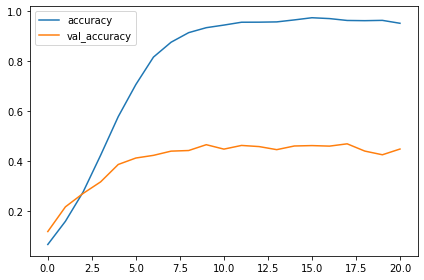

In [16]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
# history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
# print(history_frame.val_binary_accuracy)
history_frame